In [2]:
# import relevant rdkit 
from rdkit import Chem
from rdkit.Chem import Draw, rdChemReactions
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
from IPython.display import SVG, display
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yaml
from rdkit.Chem import CanonSmiles
from matplotlib import gridspec


from autocbh.data import molData
from autocbh.CBH import buildCBH
from autocbh.calcCBH import calcCBH, add_dicts
from autocbh.UQ import uncertainty_quantification, HiddenPrints
from autocbh.TN import thermochemical_network, visualize


with open('../autocbh/data/alias_manual_2.yaml', 'r') as f:
    alias = yaml.safe_load(f)
alias_rev = {v:k for k, v in alias.items()}

# Thermochemical network (rel_coeff)

In [2]:
c = calcCBH(dataframe_path='../../CBH Schemes/Franklin_v5.pkl')
c.energies.loc[c.energies.loc[:,'source'] != 'ATcT', ['DfH', 'DrxnH']] = 0.0
c.energies.loc[c.energies.loc[:,'source'] == 'ATcT', ['DrxnH']] = 0.0
c.calc_Hf(saturate=[1,9], priority='rel_coeff')

tn = thermochemical_network(c, saturate=9)

Process completed with errors in 22 species
These errors are likely to have propagated for the calculation of heats of formation of larger species.
Updating the reference values of species in the database will improve accuracy of heats of formation.
To inspect the errors, run the calcCBH.print_errors() method.


### entire TN

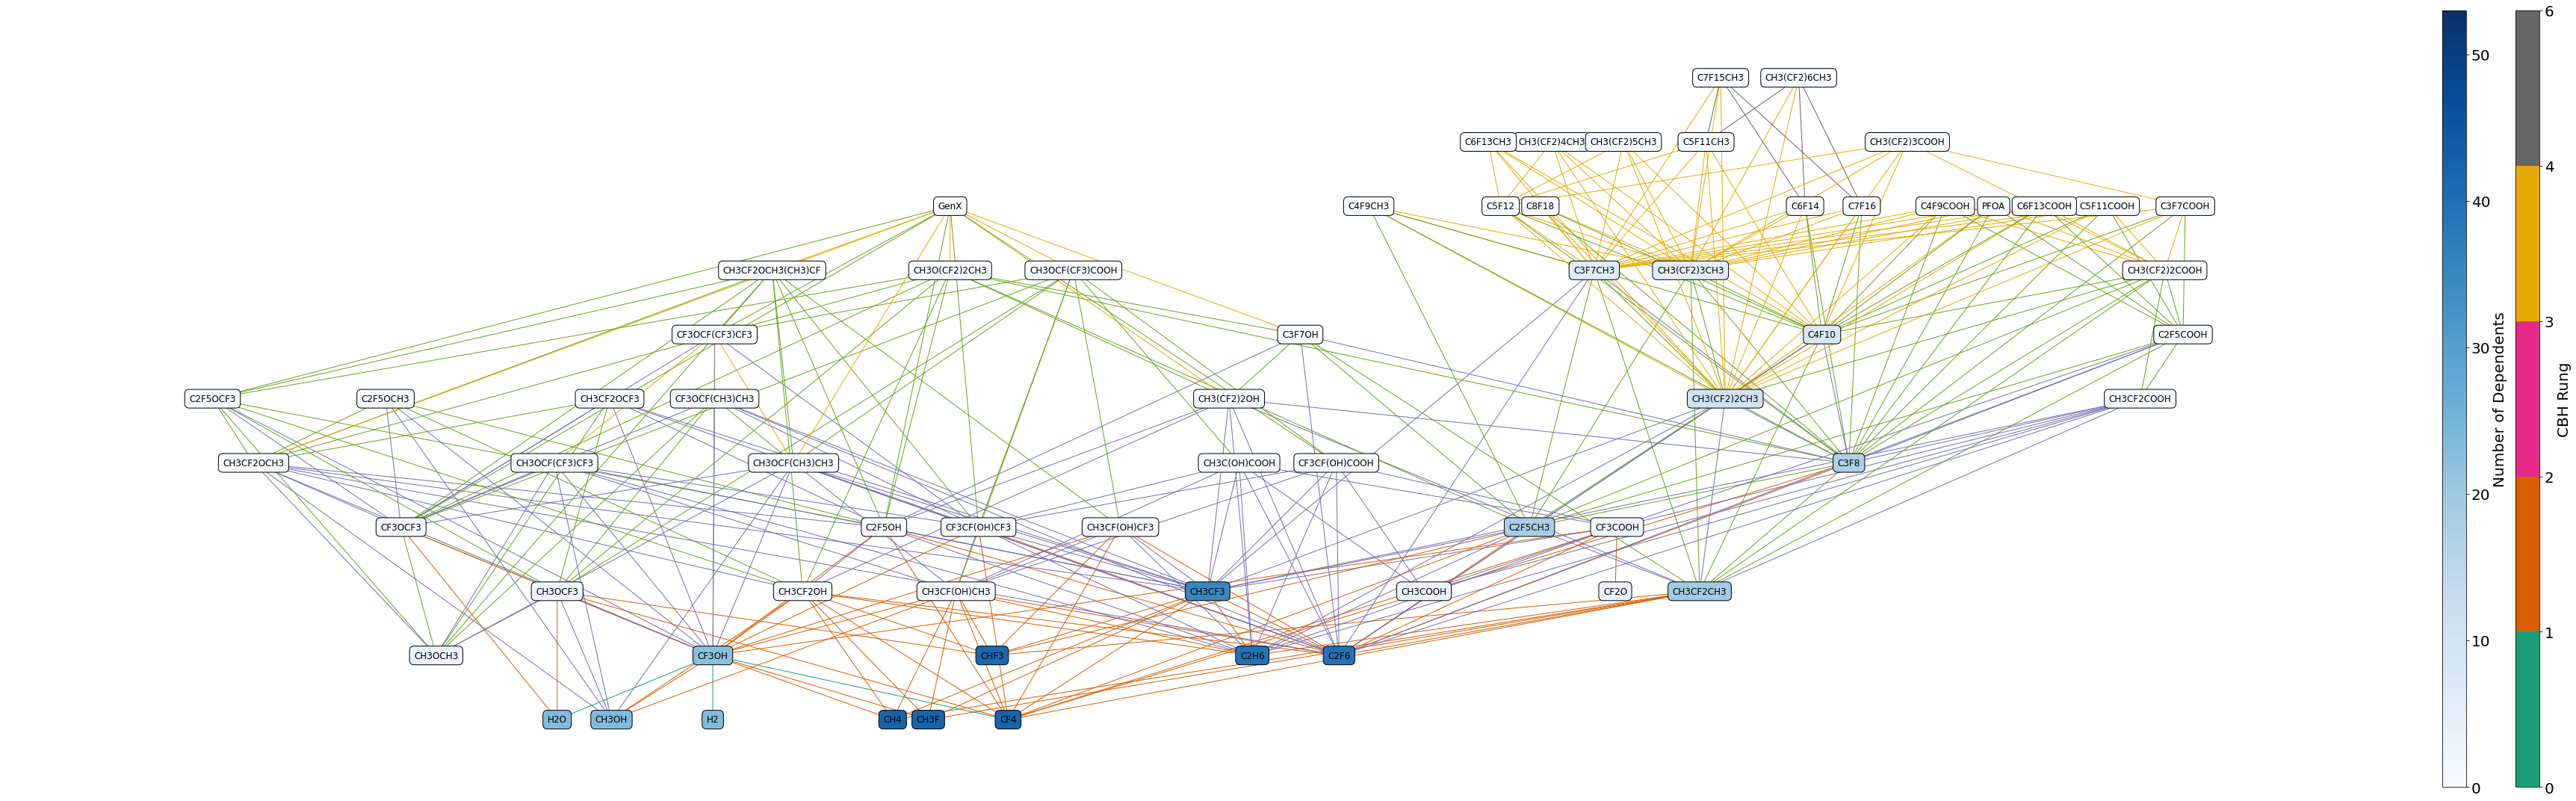

In [3]:
tn.visualize(figsize=(48,15), 
             relabel_node_mapping='data/alias_manual_2.yaml', 
             reverse_relabel_node_mapping=True, 
             label_font_size=12,
#              save_fig_path='../figures/TN_PFOA_GenX.svg'
#              edge_rank=True
            )

### PFOA subgraph

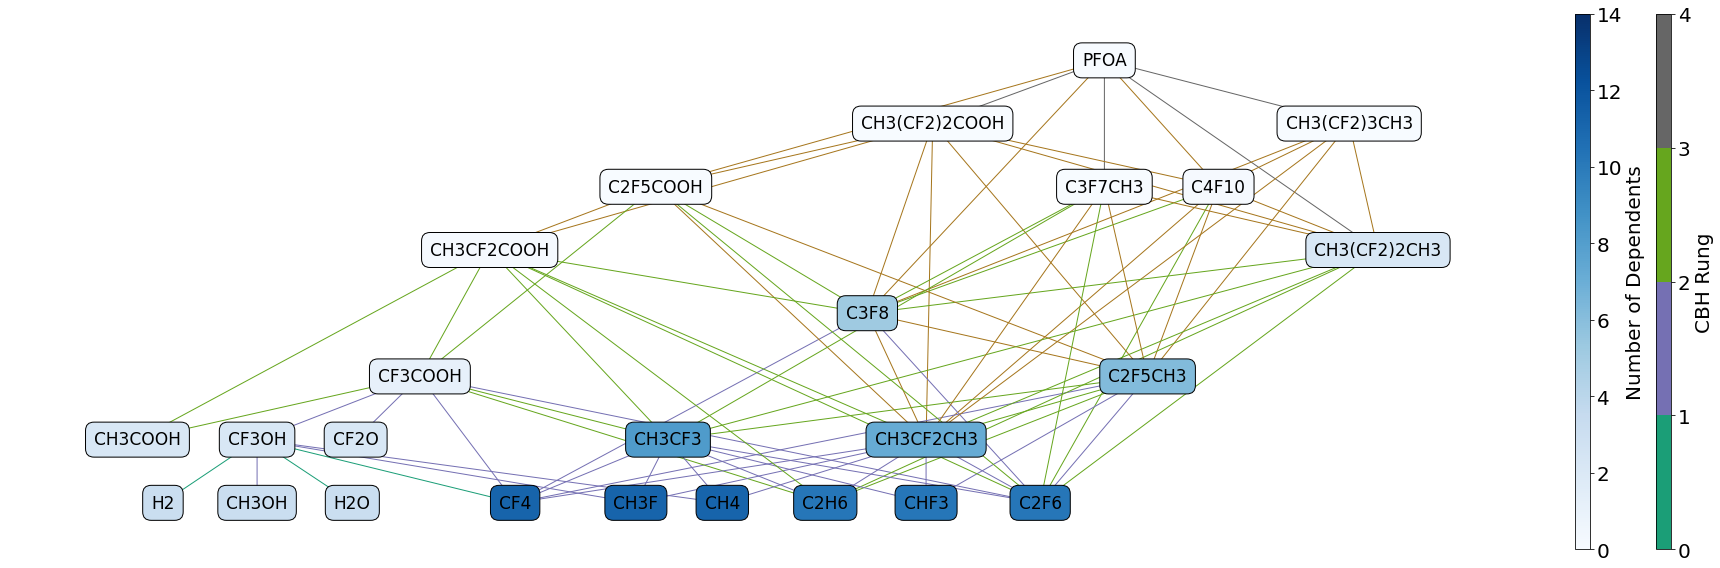

In [12]:
tn.visualize(graph=tn.descendent_subgraph_of('O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'), 
             relabel_node_mapping='data/alias_manual_2.yaml',
             reverse_relabel_node_mapping=True, label_font_size=17,
#              save_fig_path='../figures/TN_PFOA_subgraph.svg'
            )

In [13]:
len(tn.descendent_subgraph_of('O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'))

25

### GenX subraph

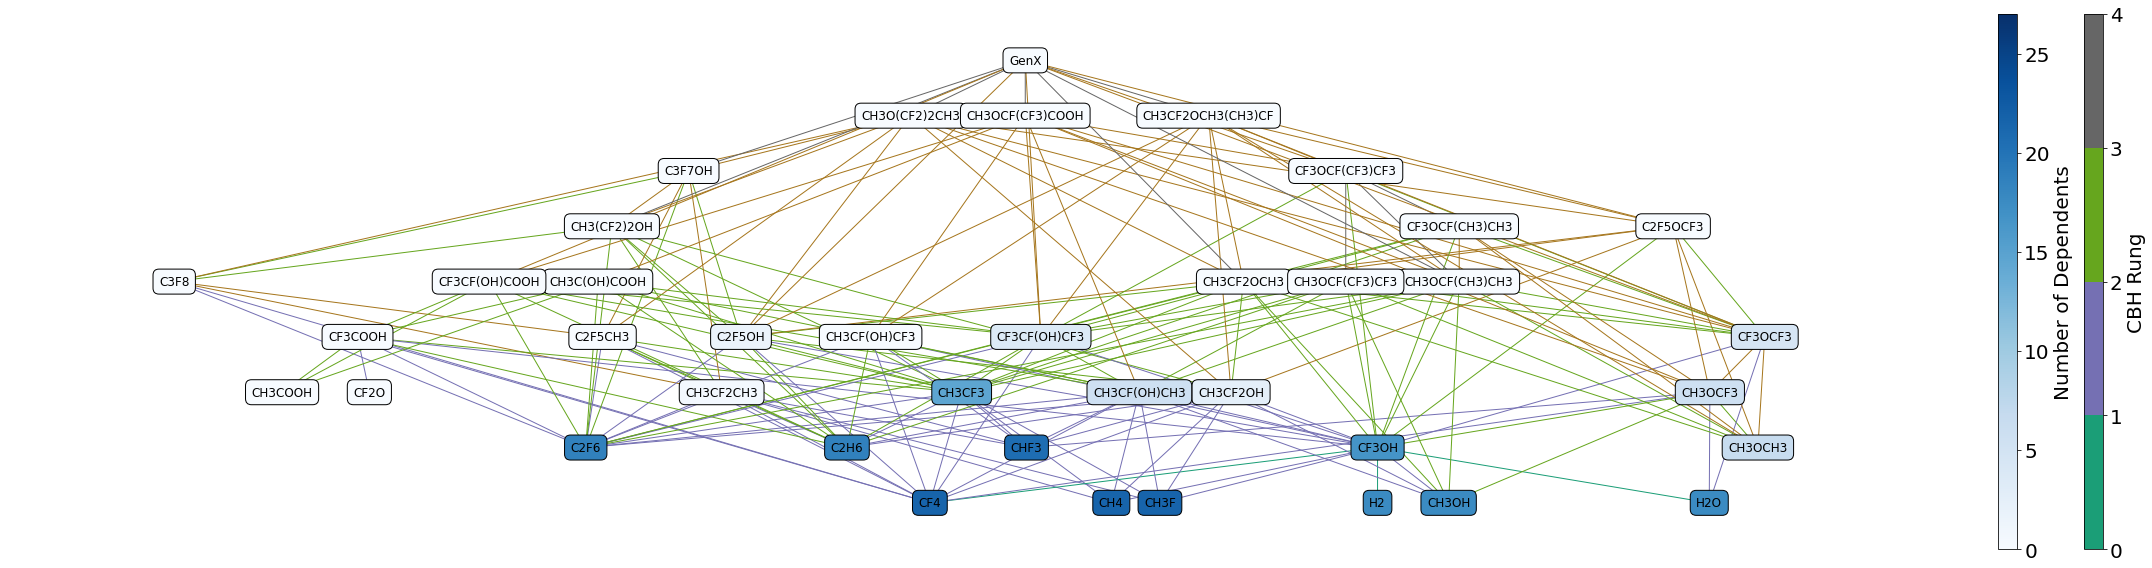

In [20]:
visualize(graph=tn.descendent_subgraph_of('O=C(O)C(F)(OC(F)(F)C(F)(F)C(F)(F)F)C(F)(F)F'), 
          relabel_node_mapping='data/alias_manual_2.yaml',
          reverse_relabel_node_mapping=True, label_font_size=12,
#           save_fig_path='../figures/TN_genx_subgraph.svg',
          figsize=(30,8)
         )

In [21]:
len(tn.descendent_subgraph_of('O=C(O)C(F)(OC(F)(F)C(F)(F)C(F)(F)F)C(F)(F)F'))

39

### Perfluorooctane

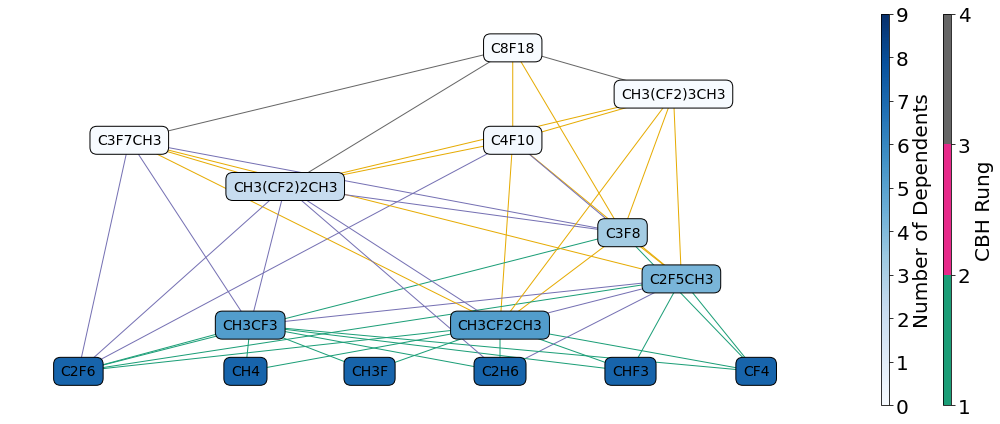

In [26]:
visualize(graph=tn.descendent_subgraph_of('FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'), 
          relabel_node_mapping='data/alias_manual_2.yaml',
          reverse_relabel_node_mapping=True, label_font_size=14,
#           save_fig_path='../figures/TN_c8f18_subgraph.svg',
          figsize=(14,6)
         )

In [27]:
len(tn.descendent_subgraph_of('FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'))

15

### perfluoroalkanes Hf for table

In [39]:
perfluoroalkanes = ['FC(F)(F)C(F)(F)F',
                    'FC(F)(F)C(F)(F)C(F)(F)F',
                    'FC(F)(F)C(F)(F)C(F)(F)C(F)(F)F',
                    'FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F',
                    'FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F', 
                    'FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F', 
                    'FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F']
c.energies.loc[perfluoroalkanes,'DfH']/4.184

smiles
FC(F)(F)C(F)(F)F                                             -318.859943
FC(F)(F)C(F)(F)C(F)(F)F                                      -416.761326
FC(F)(F)C(F)(F)C(F)(F)C(F)(F)F                               -514.312366
FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F                        -612.185090
FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F                 -710.211110
FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F          -808.459573
FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F   -906.813694
Name: DfH, dtype: float64

### Convergence

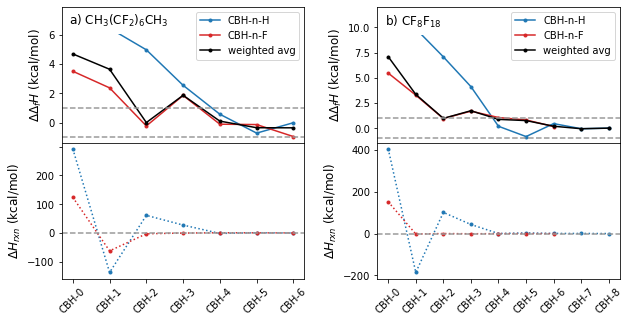

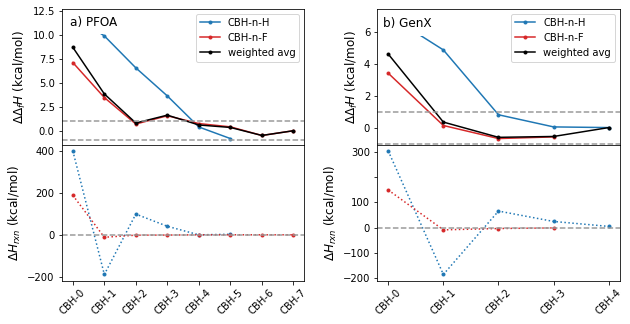

In [37]:
large_molecs = ['CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C', # ch3(cf2)6ch3
 'FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F', # c8f18
 'O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F', #pfoa
 'O=C(O)C(F)(OC(F)(F)C(F)(F)C(F)(F)F)C(F)(F)F', # genx
 ]
large_molecs = [CanonSmiles(m) for m in large_molecs]
m062x_ind = 3

fig = plt.figure(figsize=(10,5))
# set height ratios for subplots
gs = gridspec.GridSpec(2, 2,) 

# ch3(cf2)6ch3
molec = large_molecs[0]
hrxn, hf = c.calc_Hf_allrungs(molec, saturate=1)
hrxn, hf = pd.DataFrame(hrxn).iloc[3,:].values/4.184, pd.DataFrame(hf).iloc[3,:].values/4.184
hrxn_f, hf_f = c.calc_Hf_allrungs(molec, saturate=9)
hrxn_f, hf_f = pd.DataFrame(hrxn_f).iloc[3,:].values/4.184, pd.DataFrame(hf_f).iloc[3,:].values/4.184

weighted_hf = np.zeros((min(len(hrxn), len(hrxn_f))))
for i, (hr, hr_f) in enumerate(zip(hrxn, hrxn_f)):
    w, w_f = c._weight(hr, hr_f)
    weighted_hf[i] = w*hf[i] + w_f*hf_f[i]
if len(hrxn) > len(hrxn_f):
    weighted_hf = np.hstack((weighted_hf, hf[-1]))

target = hf[-1]
ax00 = plt.subplot(gs[0,0])
ax00.plot(hf - target, 'tab:blue', marker='o', ms=3)
ax00.plot(hf_f - target, 'tab:red', marker='o', ms=3)
ax00.plot(weighted_hf - target, 'k', marker='o', ms=3)
ax00.legend(['CBH-n-H', 'CBH-n-F', 'weighted avg'])
plt.axhline(1, ls='--', c='0.6')
plt.axhline(-1, ls='--', c='0.6')
ax00.annotate(r'a) CH$_3$(CF$_2$)$_6$CH$_3$', (-0.1,6.7), backgroundcolor='white', fontsize=12)
plt.ylabel(r'$\Delta \Delta_f H$ (kcal/mol)', fontsize=12)

ax10 = plt.subplot(gs[1,0], sharex = ax00)
plt.setp(ax00.get_xticklabels(), visible=False)
# remove last tick label for the second subplot
yticks = ax10.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
plt.subplots_adjust(hspace=.0, wspace=0.3)

ax10.plot(hrxn, 'tab:blue', ls=':', marker='o', ms=3)
ax10.plot(hrxn_f, 'tab:red', ls=':', marker='o', ms=3)
plt.axhline(0, ls='--', c='0.6')
ax10.set_xticks(range(len(hf)), labels=['CBH-'+str(i) for i in range(len(hf))], rotation=45)
plt.ylabel(r'$\Delta H_{rxn}$ (kcal/mol)', fontsize=12)

# c8f18
molec = large_molecs[1]
hrxn, hf = c.calc_Hf_allrungs(molec, saturate=1)
hrxn, hf = pd.DataFrame(hrxn).iloc[3,:].values/4.184, pd.DataFrame(hf).iloc[3,:].values/4.184
hrxn_f, hf_f = c.calc_Hf_allrungs(molec, saturate=9)
hrxn_f, hf_f = pd.DataFrame(hrxn_f).iloc[3,:].values/4.184, pd.DataFrame(hf_f).iloc[3,:].values/4.184

weighted_hf = np.zeros((min(len(hrxn), len(hrxn_f))))
for i, (hr, hr_f) in enumerate(zip(hrxn, hrxn_f)):
    w, w_f = c._weight(hr, hr_f)
    weighted_hf[i] = w*hf[i] + w_f*hf_f[i]
if len(hrxn) > len(hrxn_f):
    weighted_hf = np.hstack((weighted_hf, hf[-2], hf[-1]))

target = hf[-1]
ax01 = plt.subplot(gs[0,1])
ax01.plot(hf - target, 'tab:blue', marker='o', ms=3)
ax01.plot(hf_f - target, 'tab:red', marker='o', ms=3)
ax01.plot(weighted_hf - target, 'k', marker='o', ms=3)
ax01.legend(['CBH-n-H', 'CBH-n-F', 'weighted avg'])
plt.axhline(1, ls='--', c='0.6')
plt.axhline(-1, ls='--', c='0.6')
ax01.annotate(r'b) CF$_8$F$_{18}$', (-0.1,10.2), backgroundcolor='white', fontsize=12)
plt.ylabel(r'$\Delta \Delta_f H$ (kcal/mol)', fontsize=12)

ax11 = plt.subplot(gs[1,1], sharex = ax01)
plt.setp(ax01.get_xticklabels(), visible=False)
# remove last tick label for the second subplot
yticks = ax11.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
plt.subplots_adjust(hspace=.0, wspace=0.3)

ax11.plot(hrxn, 'tab:blue', ls=':', marker='o', ms=3)
ax11.plot(hrxn_f, 'tab:red', ls=':', marker='o', ms=3)
plt.axhline(0, ls='--', c='0.6')
ax11.set_xticks(range(len(hf)), labels=['CBH-'+str(i) for i in range(len(hf))], rotation=45)
plt.ylabel(r'$\Delta H_{rxn}$ (kcal/mol)', fontsize=12)

# plt.savefig('../figures/convergence_perfluoroalkanes.svg')
plt.show()

# pfoa
fig = plt.figure(figsize=(10,5))
# set height ratios for subplots
gs = gridspec.GridSpec(2, 2,) 
molec = large_molecs[2]
hrxn, hf = c.calc_Hf_allrungs(molec, saturate=1)
hrxn, hf = pd.DataFrame(hrxn).iloc[3,:].values/4.184, pd.DataFrame(hf).iloc[3,:].values/4.184
hrxn_f, hf_f = c.calc_Hf_allrungs(molec, saturate=9)
hrxn_f, hf_f = pd.DataFrame(hrxn_f).iloc[3,:].values/4.184, pd.DataFrame(hf_f).iloc[3,:].values/4.184

weighted_hf = np.zeros((min(len(hrxn), len(hrxn_f))))
for i, (hr, hr_f) in enumerate(zip(hrxn, hrxn_f)):
    w, w_f = c._weight(hr, hr_f)
    weighted_hf[i] = w*hf[i] + w_f*hf_f[i]
if len(hrxn) < len(hrxn_f):
    weighted_hf = np.hstack((weighted_hf, hf_f[-2], hf_f[-1]))

target = hf_f[-1]
ax00 = plt.subplot(gs[0,0])
ax00.plot(hf - target, 'tab:blue', marker='o', ms=3)
ax00.plot(hf_f - target, 'tab:red', marker='o', ms=3)
ax00.plot(weighted_hf - target, 'k', marker='o', ms=3)
ax00.legend(['CBH-n-H', 'CBH-n-F', 'weighted avg'])
plt.axhline(1, ls='--', c='0.6')
plt.axhline(-1, ls='--', c='0.6')
ax00.annotate(r'a) PFOA', (-0.1,11), backgroundcolor='white', fontsize=12)
plt.ylabel(r'$\Delta \Delta_f H$ (kcal/mol)', fontsize=12)

ax10 = plt.subplot(gs[1,0], sharex = ax00)
plt.setp(ax00.get_xticklabels(), visible=False)
# remove last tick label for the second subplot
yticks = ax10.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
plt.subplots_adjust(hspace=.0, wspace=0.3)

ax10.plot(hrxn, 'tab:blue', ls=':', marker='o', ms=3)
ax10.plot(hrxn_f, 'tab:red', ls=':', marker='o', ms=3)
plt.axhline(0, ls='--', c='0.6')
ax10.set_xticks(range(len(hrxn_f)), labels=['CBH-'+str(i) for i in range(len(hrxn_f))], rotation=45)
plt.ylabel(r'$\Delta H_{rxn}$ (kcal/mol)', fontsize=12)

# genx
molec = large_molecs[3]
hrxn, hf = c.calc_Hf_allrungs(molec, saturate=1)
hrxn, hf = pd.DataFrame(hrxn).iloc[3,:].values/4.184, pd.DataFrame(hf).iloc[3,:].values/4.184
hrxn_f, hf_f = c.calc_Hf_allrungs(molec, saturate=9)
hrxn_f, hf_f = pd.DataFrame(hrxn_f).iloc[3,:].values/4.184, pd.DataFrame(hf_f).iloc[3,:].values/4.184

weighted_hf = np.zeros((min(len(hrxn), len(hrxn_f))))
for i, (hr, hr_f) in enumerate(zip(hrxn, hrxn_f)):
    w, w_f = c._weight(hr, hr_f)
    weighted_hf[i] = w*hf[i] + w_f*hf_f[i]
if len(hrxn) > len(hrxn_f):
    weighted_hf = np.hstack((weighted_hf, hf[-1]))

target = hf[-1]
ax01 = plt.subplot(gs[0,1])
ax01.plot(hf - target, 'tab:blue', marker='o', ms=3)
ax01.plot(hf_f - target, 'tab:red', marker='o', ms=3)
ax01.plot(weighted_hf - target, 'k', marker='o', ms=3)
ax01.legend(['CBH-n-H', 'CBH-n-F', 'weighted avg'])
plt.axhline(1, ls='--', c='0.6')
plt.axhline(-1, ls='--', c='0.6')
ax01.annotate(r'b) GenX', (-0.1,6.3), backgroundcolor='white', fontsize=12)
plt.ylabel(r'$\Delta \Delta_f H$ (kcal/mol)', fontsize=12)

ax11 = plt.subplot(gs[1,1], sharex = ax01)
plt.setp(ax01.get_xticklabels(), visible=False)
# remove last tick label for the second subplot
yticks = ax11.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
plt.subplots_adjust(hspace=.0, wspace=0.3)

ax11.plot(hrxn, 'tab:blue', ls=':', marker='o', ms=3)
ax11.plot(hrxn_f, 'tab:red', ls=':', marker='o', ms=3)
plt.axhline(0, ls='--', c='0.6')
ax11.set_xticks(range(len(hf)), labels=['CBH-'+str(i) for i in range(len(hf))], rotation=45)
plt.ylabel(r'$\Delta H_{rxn}$ (kcal/mol)', fontsize=12)
# plt.savefig('../figures/convergence_pfoa_genx.svg')
plt.show()

### compare autoCBH results with manual

In [26]:
# initialized for simple sort
uq = uncertainty_quantification(10000, calcCBH_obj=c)

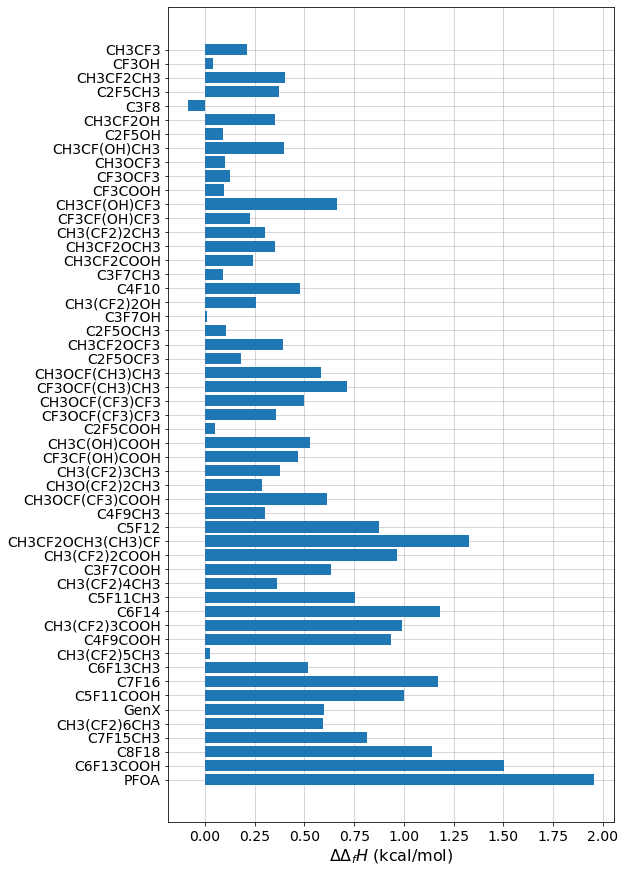

In [25]:
#### MUST INITIALIZE UQ FIRST TO USE UQ.SIMPLE_SORT ####
manual = pd.read_pickle('../../CBH Schemes/Franklin_v5.pkl')
compare_with_manual = c.energies.loc[:, 'DfH'] - manual.loc[:,'DfH']
compare_with_manual = pd.DataFrame(compare_with_manual, columns=['DfH'])
compare_with_manual['name'] = compare_with_manual.index.to_series().map(alias_rev)
compare_with_manual.drop(labels=manual[manual.loc[:,'source'] == 'ATcT'].index.values, inplace=True)
# compare_with_manual.set_index('name', inplace=True)
# compare_with_manual
sorted_inds = sorted(compare_with_manual.index.values, key=uq.simple_sort)

fig, ax = plt.subplots(1, 1, figsize=(8,15))
ax.barh(np.arange(len(compare_with_manual)), compare_with_manual.loc[sorted_inds, 'DfH'].iloc[::-1].values/4.184)
ax.set_yticks(ticks=np.arange(len(compare_with_manual)), labels = compare_with_manual.loc[sorted_inds, 'name'].iloc[::-1], 
           fontsize=14)
plt.xticks(fontsize=14)
ax.set_axisbelow(True)
ax.grid(visible=True, alpha=0.4, color='gray')
plt.xlabel(r'$\Delta \Delta_fH$ (kcal/mol)', fontsize=16)
# plt.savefig('../figures/compare_autoCBH_manual.svg')
plt.show()

### generate latex table of autoCBH outputs

In [38]:
def to_latex_chem(string:str):
    if string != 'PFOA' or string != 'GenX':
        return 'ce{' + string + '}'
    else:
        return string

In [30]:
#### MUST INITIALIZE UQ FIRST TO USE UQ.SIMPLE_SORT ####
df = c.energies.loc[:,['DfH', 'DrxnH', 'source']].copy()
df['name'] = df.index.map(alias_rev)
df = df[['name', 'DfH', 'DrxnH', 'source']]
sorted_inds = sorted(df.index.values, key=uq.simple_sort)
df = df.loc[sorted_inds,:]
df['name'] = df['name'].apply(to_latex_chem)
# df
# print(df.reset_index().to_latex(index=False, longtable=True, column_format='l|l|c|c|r', float_format="%.2f"))

# Uncertainty Quantification

In [2]:
uq = uncertainty_quantification(10000, dataframe_path='../../CBH Schemes/Franklin_v5.pkl', saturate=[1,9], 
                           priority='rel_coeff', alt_rxn_option="ignore")
uq.run()

Process completed with errors in 22 species
These errors are likely to have propagated for the calculation of heats of formation of larger species.
Updating the reference values of species in the database will improve accuracy of heats of formation.
To inspect the errors, run the calcCBH.print_errors() method.


Number of Species: 100%|██████████████████████████████████████| 53/53 [00:03<00:00, 15.83it/s]


In [3]:
tn = thermochemical_network(uq.calcCBH)

### PFOA UQ

In [4]:
normalized_simresults = uq.simulation_results - np.expand_dims(uq.simulation_results.mean(axis=1), axis=-1)
df = pd.DataFrame(normalized_simresults, index=uq.species)
(df.std(axis=1)/4.184).values
# (df.abs().max(axis=1)/4.184).values

array([0.        , 0.00229225, 0.00570442, 0.02782577, 0.03929497,
       0.04517224, 0.02748335, 0.01428661, 0.11809475, 0.0986071 ,
       0.01933615, 0.15275699, 0.26364565, 0.20594207, 0.35432161,
       0.00297594, 0.01148954, 0.0474453 , 0.01807336, 0.02303942,
       0.02525129, 0.12352762, 0.10589604, 0.03220765, 0.15726018,
       0.04421442, 0.04718972, 0.04575038, 0.06785853, 0.13315289,
       0.04312812, 0.10761568, 0.07145376, 0.24668673, 0.35198882,
       0.32464945, 0.59078109, 0.24158534, 0.21934792, 0.26966849,
       0.23016807, 0.11411621, 0.15735615, 0.11226844, 0.27207631,
       0.31437705, 0.36406699, 0.25906896, 0.25285847, 0.2410615 ,
       0.29715584, 0.30872889, 0.37997959, 0.5621681 , 0.45500112,
       0.75370232, 0.64372639, 0.58889038, 0.8764066 , 0.77170523,
       0.72382909, 1.01640759, 0.92031592, 0.86129017, 0.48467313,
       0.4434158 , 0.38736248, 0.66848846, 0.53196926, 0.67025796,
       0.80598755, 0.94018309, 0.56738818])

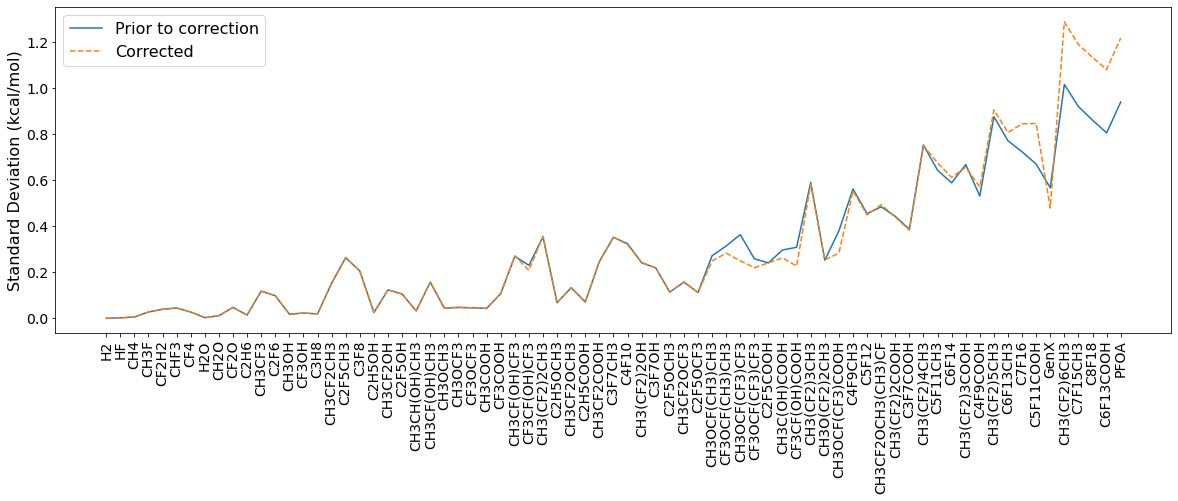

In [11]:
# with len(set(source_rank))==1
with_hetero_std = np.array([0.        , 0.00229225, 0.00570442, 0.02782577, 0.03929497,
       0.04517224, 0.02748335, 0.01428661, 0.11809475, 0.0986071 ,
       0.01933615, 0.15275699, 0.26364565, 0.20594207, 0.35432161,
       0.00297594, 0.01148954, 0.0474453 , 0.01807336, 0.02303942,
       0.02525129, 0.12352762, 0.10589604, 0.03220765, 0.15726018,
       0.04421442, 0.04718972, 0.04575038, 0.06785853, 0.13315289,
       0.04312812, 0.10761568, 0.07145376, 0.24668673, 0.35198882,
       0.32464945, 0.59078109, 0.24158534, 0.21934792, 0.26966849,
       0.23016807, 0.11411621, 0.15735615, 0.11226844, 0.27207631,
       0.31437705, 0.36406699, 0.25906896, 0.25285847, 0.2410615 ,
       0.29715584, 0.30872889, 0.37997959, 0.5621681 , 0.45500112,
       0.75370232, 0.64372639, 0.58889038, 0.8764066 , 0.77170523,
       0.72382909, 1.01640759, 0.92031592, 0.86129017, 0.48467313,
       0.4434158 , 0.38736248, 0.66848846, 0.53196926, 0.67025796,
       0.80598755, 0.94018309, 0.56738818])
# without len(set(source_rank))==1
without_hetero_std = np.array([0.        , 0.00227608, 0.00572508, 0.02767937, 0.03988998,
       0.04508461, 0.02750631, 0.01444402, 0.11892703, 0.09825702,
       0.01933105, 0.15350658, 0.26524746, 0.20554699, 0.35640487,
       0.00296197, 0.01153692, 0.04813465, 0.01811192, 0.02289197,
       0.02479713, 0.12442053, 0.10589731, 0.0323856 , 0.15796377,
       0.04497561, 0.04830313, 0.04611874, 0.06820054, 0.13384993,
       0.04327216, 0.1075506 , 0.07034257, 0.24803713, 0.35346492,
       0.31999311, 0.58219485, 0.2430528 , 0.21941687, 0.27137263,
       0.20853539, 0.11434122, 0.15869521, 0.11216863, 0.24882549,
       0.28337681, 0.24961539, 0.22027291, 0.25409783, 0.24137053,
       0.26280068, 0.22726764, 0.28322787, 0.55331426, 0.44968537,
       0.74992693, 0.67608441, 0.61242479, 0.9059563 , 0.80750356,
       0.84511439, 1.28862206, 1.19002189, 1.13388533, 0.49398328,
       0.44038954, 0.38288726, 0.65667355, 0.5710026 , 0.84685393,
       1.08137652, 1.21828149, 0.47961068])

sorted_inds = sorted(uq.species, key=uq.simple_sort)
alias_sorted_names = [alias_rev[s] for s in sorted_inds]

sorted_inds = [uq.species.tolist().index(s) for s in sorted_inds]

plt.figure(figsize=(20,6))
plt.plot(np.arange(len(with_hetero_std)), with_hetero_std[sorted_inds])
plt.plot(np.arange(len(without_hetero_std)), without_hetero_std[sorted_inds], '--')
plt.legend(['Prior to correction', 'Corrected'], fontsize=16)

plt.xticks(ticks=np.arange(len(with_hetero_std)), labels=alias_sorted_names, rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Standard Deviation (kcal/mol)', fontsize=16)
plt.show()

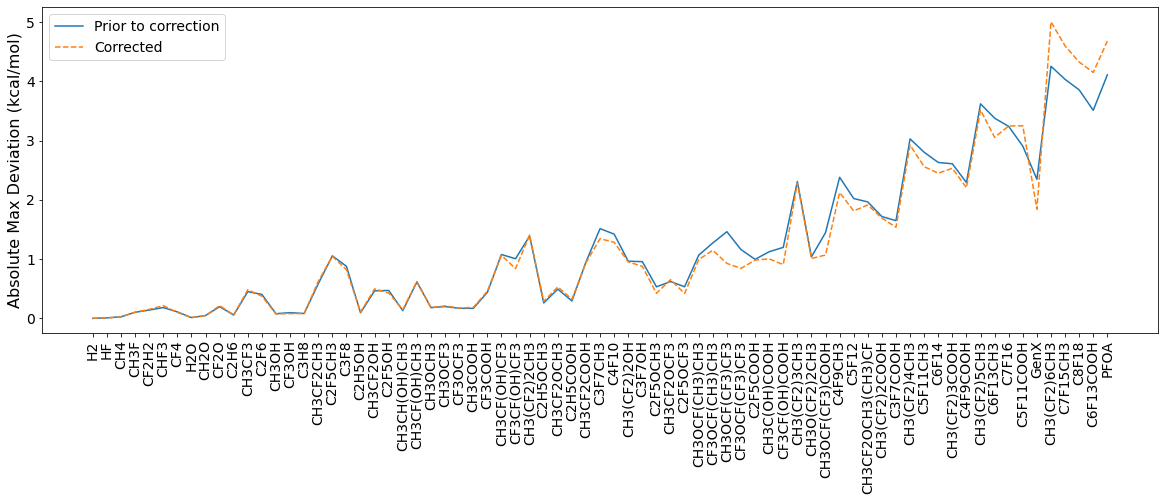

In [10]:
with_hetero = np.array([0.        , 0.00844135, 0.0259316 , 0.10239757, 0.13938342,
       0.1824139 , 0.10846291, 0.05683542, 0.4509315 , 0.40369195,
       0.08161544, 0.5832416 , 1.05407664, 0.87804044, 1.38897784,
       0.01304351, 0.04760738, 0.19656057, 0.07830039, 0.0959078 ,
       0.0947156 , 0.46361037, 0.47075513, 0.12955516, 0.61394297,
       0.18068041, 0.19924066, 0.16926519, 0.25933676, 0.4934277 ,
       0.16831606, 0.43787965, 0.29324101, 0.95263329, 1.51407172,
       1.41994462, 2.30944678, 0.96416754, 0.95654117, 1.07735221,
       1.00557553, 0.53186439, 0.62091622, 0.53281506, 1.0659583 ,
       1.27200263, 1.46166262, 1.16029733, 1.03693184, 0.99547649,
       1.1236508 , 1.19710945, 1.44646618, 2.37996771, 2.02141762,
       3.02782605, 2.80202206, 2.62991158, 3.61918443, 3.37743765,
       3.23794113, 4.25272333, 4.03188358, 3.85481021, 1.96405509,
       1.71710547, 1.64787788, 2.60769626, 2.29019096, 2.90530369,
       3.50981694, 4.10801967, 2.34648063])
without_hetero = np.array([0.        , 0.00888642, 0.02369935, 0.10325971, 0.1514164 ,
       0.21438731, 0.10064284, 0.05774689, 0.4828512 , 0.37325978,
       0.08054712, 0.62243369, 1.04740791, 0.82092618, 1.40572555,
       0.01185952, 0.0463604 , 0.21410372, 0.07375851, 0.08044758,
       0.10473809, 0.4973298 , 0.42620069, 0.14912289, 0.62067815,
       0.18099519, 0.20988223, 0.17407131, 0.28619309, 0.5312112 ,
       0.18417401, 0.45703521, 0.32092247, 0.94036273, 1.34370216,
       1.28302449, 2.28268225, 0.95300972, 0.87649812, 1.06435277,
       0.83877805, 0.42279999, 0.65216767, 0.4184159 , 0.99081524,
       1.14825271, 0.92700073, 0.84204967, 1.00946275, 0.9827882 ,
       1.00329343, 0.90650383, 1.06883795, 2.12247712, 1.8131963 ,
       2.92253566, 2.55894373, 2.44791428, 3.51436859, 3.05282119,
       3.24511518, 5.00230783, 4.59556166, 4.32438917, 1.9127021 ,
       1.69107496, 1.53628723, 2.53159542, 2.20397654, 3.24920543,
       4.1482953 , 4.67854537, 1.84059895])
sorted_inds = sorted(uq.species, key=uq.simple_sort)
alias_sorted_names = [alias_rev[s] for s in sorted_inds]

sorted_inds = [uq.species.tolist().index(s) for s in sorted_inds]

plt.figure(figsize=(20,6))
plt.plot(np.arange(len(with_hetero)), with_hetero[sorted_inds])
plt.plot(np.arange(len(without_hetero)), without_hetero[sorted_inds], '--')
plt.legend(['Prior to correction', 'Corrected'], fontsize=14)

plt.xticks(ticks=np.arange(len(with_hetero)), labels=alias_sorted_names, rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Absolute Max Deviation (kcal/mol)', fontsize=16)
plt.show()

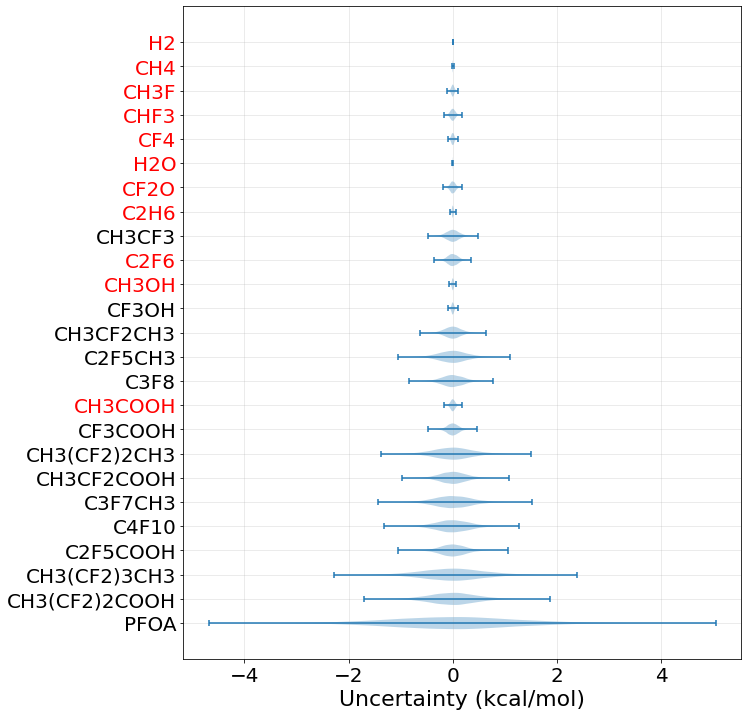

In [8]:
subgraph = tn.descendent_subgraph_of('O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F')
inds = [s in list(subgraph.nodes) for i, s in enumerate(uq.species)]

normalized_simresults = uq.simulation_results[inds] - np.expand_dims(uq.simulation_results[inds].mean(axis=1), axis=-1)
df = pd.DataFrame(normalized_simresults, index=uq.species[inds])
sorted_inds = sorted(df.index.values, key=uq.simple_sort)[::-1]
alias_sorted_names = [alias_rev[s] for s in sorted_inds]

exp_smiles = [s for s in uq.species[inds] if len(uq.calcCBH.energies.loc[s,'source'].split('//'))==1]

fig, ax = plt.subplots(1,1, figsize=(10,12))
ax.violinplot(df.loc[sorted_inds].T/4.184, vert=False)
ax.set_yticks(ticks=np.arange(len(alias_sorted_names))+1, labels=alias_sorted_names, fontsize=20)
plt.xticks(fontsize=20)
for s in exp_smiles:
    if alias_rev[s] in alias_sorted_names:
        ind = alias_sorted_names.index(alias_rev[s])
        ax.get_yticklabels()[ind].set_color("red")
plt.grid(True, axis='both', alpha=0.3)
plt.xlabel('Uncertainty (kcal/mol)', fontsize=22)
# plt.savefig('../figures/UQ_pfoa_rel.svg')
plt.show()

In [18]:
print('Max error:\n', df.abs().max(axis=1).max()/4.184)
print('Stddev:\n', df.std(axis=1)/4.184)

Max error:
 2.384598254705423
Stddev:
 [H][H]                                        0.000000
C                                             0.005719
CF                                            0.027696
FC(F)F                                        0.045004
FC(F)(F)F                                     0.027943
CC                                            0.014333
CC(F)(F)F                                     0.116930
FC(F)(F)C(F)(F)F                              0.097708
CC(C)(F)F                                     0.151019
CC(F)(F)C(F)(F)F                              0.260743
FC(F)(F)C(F)(F)C(F)(F)F                       0.203598
O                                             0.002972
O=C(F)F                                       0.048000
CO                                            0.017727
OC(F)(F)F                                     0.023353
CC(O)(F)F                                     0.122315
OC(F)(F)C(F)(F)F                              0.105140
CC(C)(O)F                 

### GenX UQ

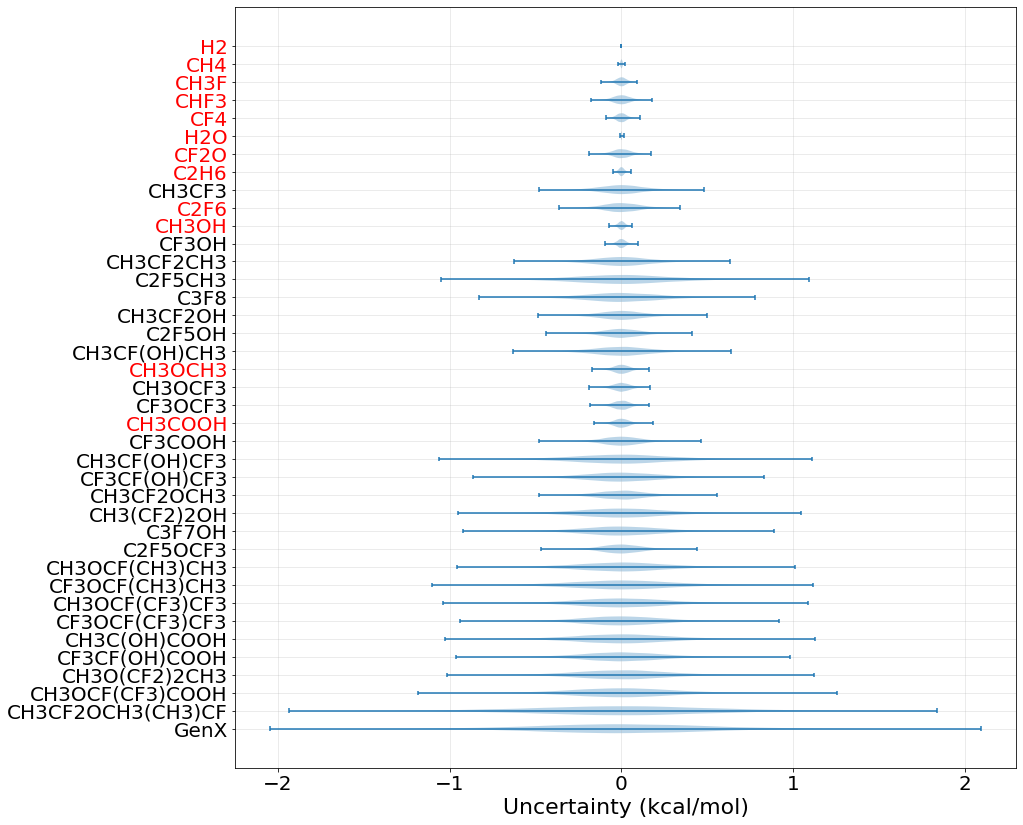

In [7]:
subgraph = tn.descendent_subgraph_of('O=C(O)C(F)(OC(F)(F)C(F)(F)C(F)(F)F)C(F)(F)F')
inds = [s in list(subgraph.nodes) for i, s in enumerate(uq.species)]

normalized_simresults = uq.simulation_results[inds] - np.expand_dims(uq.simulation_results[inds].mean(axis=1), axis=-1)
df = pd.DataFrame(normalized_simresults, index=uq.species[inds])
sorted_inds = sorted(df.index.values, key=uq.simple_sort)[::-1]
alias_sorted_names = [alias_rev[s] for s in sorted_inds]

exp_smiles = [s for s in uq.species[inds] if len(uq.calcCBH.energies.loc[s,'source'].split('//'))==1]

fig, ax = plt.subplots(1,1, figsize=(14,14))
ax.violinplot(df.loc[sorted_inds].T/4.184, vert=False)
ax.set_yticks(ticks=np.arange(len(alias_sorted_names))+1, labels=alias_sorted_names, fontsize=20)
plt.xticks(fontsize=20)
for s in exp_smiles:
    if alias_rev[s] in alias_sorted_names:
        ind = alias_sorted_names.index(alias_rev[s])
        ax.get_yticklabels()[ind].set_color("red")
plt.grid(True, axis='both', alpha=0.3)
plt.xlabel('Uncertainty (kcal/mol)', fontsize=22)
# plt.savefig('../figures/UQ_genx_rel.svg')
plt.show()

In [16]:
print('Max error:', df.abs().max(axis=1).max()/4.184)
print('Stddev:\n', df.std(axis=1)/4.184)

Max error: 2.384598254705423
Stddev:
 [H][H]                                        0.000000
C                                             0.005719
CF                                            0.027696
FC(F)F                                        0.045004
FC(F)(F)F                                     0.027943
CC                                            0.014333
CC(F)(F)F                                     0.116930
FC(F)(F)C(F)(F)F                              0.097708
CC(C)(F)F                                     0.151019
CC(F)(F)C(F)(F)F                              0.260743
FC(F)(F)C(F)(F)C(F)(F)F                       0.203598
O                                             0.002972
O=C(F)F                                       0.048000
CO                                            0.017727
OC(F)(F)F                                     0.023353
CC(O)(F)F                                     0.122315
OC(F)(F)C(F)(F)F                              0.105140
CC(C)(O)F                  

# Adsorbates

In [34]:
ads = calcCBH(methods=['beef_vdw'], dataframe_path='../../Adsorbate CBH/adsorbate_data.pkl')
ads.energies.drop(['O=[Pt]', '[PtH]', '[H][H].[Pt]'], inplace=True)
ads.calc_Hf(saturate=[1], surface_smiles='[Pt]')

Process completed with errors in 16 species
These errors are likely to have propagated for the calculation of heats of formation of larger species.
Updating the reference values of species in the database will improve accuracy of heats of formation.
To inspect the errors, run the calcCBH.print_errors() method.


,DfH,DrxnH,source
O=CC#[Pt],-196.892993,68.392993,CBH-1-H//beef_vdw
CC(C)=[Pt],-12.115316,29.215316,CBH-1-H//beef_vdw
COC.[Pt],-239.088211,16.988211,CBH-1-H//beef_vdw
C.[Pt],-81.300000,0.000000,exp
OC[Pt],-242.702394,31.802394,CBH-1-H//beef_vdw
...,...,...,...
CC=O.[Pt],-225.333279,51.333279,CBH-1-H//beef_vdw
COCO.[Pt],-450.609601,64.809601,CBH-1-H//beef_vdw
CCC.[Pt],-120.756061,10.056061,CBH-1-H//beef_vdw
O=C=C[Pt],-117.446471,95.646471,CBH-1-H//beef_vdw


In [35]:
ads.print_errors()

[Pt]=CC=[Pt]:

	All precursor species for CBH-2-H had the same level of theory. 
	The reaction was decomposed into each precursors' substituents which was found to be equivalent to CBH-1-H.
	Moving down to CBH-1-H.


[Pt]CC[Pt]:

	All precursor species for CBH-2-H had the same level of theory. 
	The reaction was decomposed into each precursors' substituents which was found to be equivalent to CBH-1-H.
	Moving down to CBH-1-H.


O=C=C[Pt]:

	All precursor species for CBH-2-H had the same level of theory. 
	The reaction was decomposed into each precursors' substituents which was found to be equivalent to CBH-1-H.
	Moving down to CBH-1-H.


CC([Pt])C[Pt]:

	All precursor species for CBH-2-H had the same level of theory. 
	The reaction was decomposed into each precursors' substituents which was found to be equivalent to CBH-1-H.
	Moving down to CBH-1-H.


COC=O.[Pt]:

	All precursor species for CBH-2-H had the same level of theory. 
	The reaction was decomposed into each precursors' substi

In [36]:
ads_order = ['C=C=[Pt]','CC#[Pt]','CC[Pt]','CC=[Pt]','C=CC#[Pt]','CCC[Pt]','C=C(C)[Pt]','CC(C)[Pt]',
             'C=C=C=[Pt]','CCC#[Pt]','C=C=C[Pt]','CCC=[Pt]','CC(C)=[Pt]','C=C[Pt]','CO[Pt]','OC#[Pt]',
             'OC[Pt]','O=C[Pt]','OC=[Pt]','O=C(O)[Pt]','CC(=O)[Pt]','O=C=C[Pt]','COCO[Pt]','CCO[Pt]',
             'O=CO[Pt]','OCC#[Pt]','O=CC#[Pt]','O=C=C=[Pt]','CCC(=O)[Pt]','CC(O)[Pt]','CC(O)=[Pt]',
             'OCO[Pt]','O=C(O)O[Pt]','[Pt]=C=C=[Pt]','[Pt]=CC=[Pt]','[Pt]CC[Pt]','[Pt]CC=[Pt]','[Pt]C=C=[Pt]',
             '[Pt]C=CC[Pt]','CC([Pt])C=[Pt]','[Pt]CC([Pt])C[Pt]','C=C([Pt])C#[Pt]','CC([Pt])C[Pt]','[Pt]OC=[Pt]',
             '[Pt]CO[Pt]','[Pt]OCO[Pt]','O=C(O[Pt])O[Pt]','C=CC.[Pt]','CCC.[Pt]','C=C=C.[Pt]','O=C=O.[Pt]',
             'O=CO.[Pt]','COC=O.[Pt]','C=C=O.[Pt]','CCO.[Pt]','CC=O.[Pt]','COC.[Pt]','OCO.[Pt]','O=C(O)O.[Pt]',
             'COCO.[Pt]']

In [37]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(ads.energies.loc[ads_order,['source', 'DrxnH', 'DfH']])

                              source      DrxnH         DfH
C=C=[Pt]           CBH-1-H//beef_vdw  16.403582  166.303582
CC#[Pt]            CBH-1-H//beef_vdw  42.907753  -93.407753
CC[Pt]             CBH-1-H//beef_vdw  10.182271  -72.082271
CC=[Pt]            CBH-1-H//beef_vdw  18.265131   13.534869
C=CC#[Pt]          CBH-1-H//beef_vdw  65.561427  -12.661427
CCC[Pt]            CBH-1-H//beef_vdw  15.528011  -92.128011
C=C(C)[Pt]         CBH-1-H//beef_vdw  91.371379  -49.871379
CC(C)[Pt]          CBH-1-H//beef_vdw  19.927742  -96.527742
C=C=C=[Pt]         CBH-1-H//beef_vdw  85.497352  167.802648
CCC#[Pt]           CBH-1-H//beef_vdw  51.073084 -116.273084
C=C=C[Pt]          CBH-1-H//beef_vdw  61.823814   97.776186
CCC=[Pt]           CBH-1-H//beef_vdw  12.648784    4.451216
CC(C)=[Pt]         CBH-1-H//beef_vdw  29.215316  -12.115316
C=C[Pt]            CBH-1-H//beef_vdw  17.720264   38.479736
CO[Pt]             CBH-1-H//beef_vdw  21.782838 -163.582838
OC#[Pt]            CBH-1-H//beef_vdw  66

In [32]:
tn_ads = thermochemical_network(ads, surface_smiles='[Pt]')
tn_ads.build()

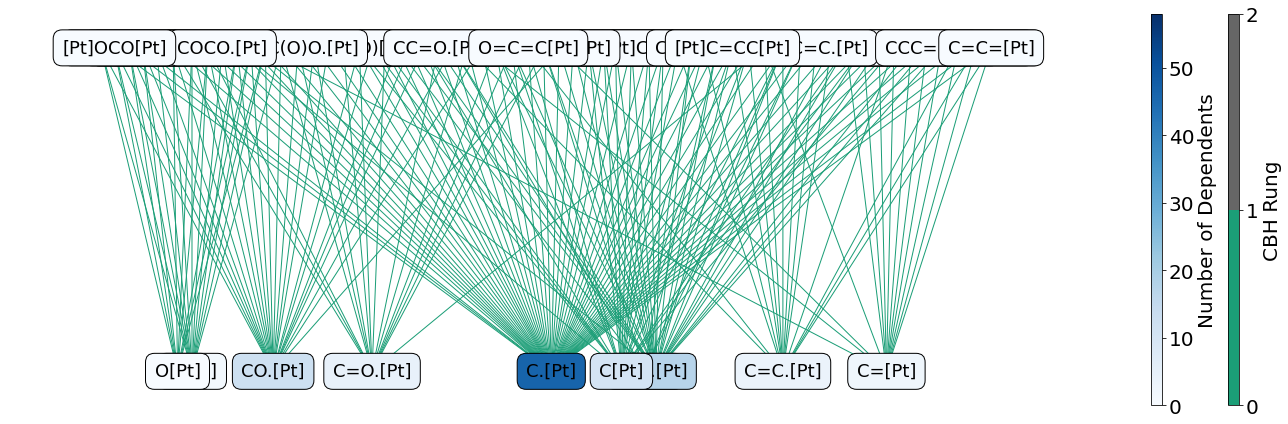

In [33]:
tn_ads.visualize(figsize=(18,6),
#                  save_fig_path='../figures/TN_ads.svg',
                 label_font_size=18
                )

In [9]:
def time_test_ads():
    with HiddenPrints():
        ads = calcCBH(methods=['beef_vdw'], dataframe_path='../../Adsorbate CBH/adsorbate_data.pkl')
        ads.energies.drop(['O=[Pt]', '[PtH]', '[H][H].[Pt]'], inplace=True)
        ads.calc_Hf(saturate=[1], surface_smiles='[Pt]')
    
%timeit -n10 time_test_ads()

677 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [65]:
compare_ads = pd.read_excel('../../Adsorbate CBH/compare_kreitz_autoCBH.xlsx', index_col=0, header=[0,1],
                            converters={'(DrxnH, Bjarne)':float,'(DrxnH, autoCBH)':float, 
                                        '(DfH, Bjarne)':float, '(DfH, autoCBH)':float})
compare_ads = compare_ads.astype(float)
print(compare_ads.reset_index().to_latex(index=False, longtable=True, column_format='l|c|c|c|c', float_format="%.2f"))

\begin{longtable}{l|c|c|c|c}
\toprule
             index & \multicolumn{2}{l}{DrxnH} & \multicolumn{2}{l}{DfH} \\
                   &  Bjarne & autoCBH &  Bjarne & autoCBH \\
\midrule
\endfirsthead

\toprule
             index & \multicolumn{2}{l}{DrxnH} & \multicolumn{2}{l}{DfH} \\
                   &  Bjarne & autoCBH &  Bjarne & autoCBH \\
\midrule
\endhead
\midrule
\multicolumn{5}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
          C=C=[Pt] &   16.40 &   16.40 &  166.30 &  166.30 \\
          CC\#[Pt]  &  -42.90 &   42.91 &  -93.40 &  -93.41 \\
           CC[Pt]  &  -10.20 &   10.18 &  -72.10 &  -72.08 \\
           CC=[Pt] &  -18.30 &   18.27 &   13.50 &   13.53 \\
         C=CC\#[Pt] &  -65.60 &   65.56 &  -12.70 &  -12.66 \\
          CCC[Pt]  &  -15.50 &   15.53 &  -92.10 &  -92.13 \\
       C=C(C)[Pt]  &  -91.40 &   91.37 &  -49.90 &  -49.87 \\
        CC(C)[Pt]  &  -19.90 &   19.93 &  -96.50 &  -96.53 \\
       C=C=C=[Pt]  &  -85.50 &   85.

/var/folders/vj/3839yjts35154mqrfvvw7b7c0000gn/T/ipykernel_88163/1717597522.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(compare_ads.reset_index().to_latex(index=False, longtable=True, column_format='l|c|c|c|c', float_format="%.2f"))


# Extra methods


-----------------------------------------------------------------------------------------------------

CBH RUNG 0

Reactants:


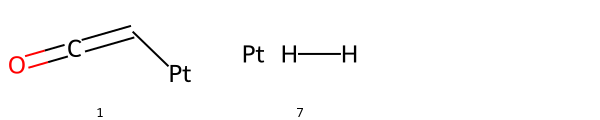


Products:


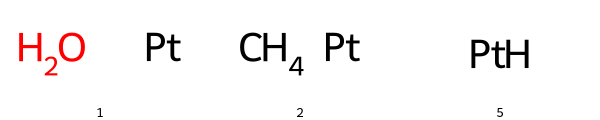


-----------------------------------------------------------------------------------------------------

CBH RUNG 1

Reactants:


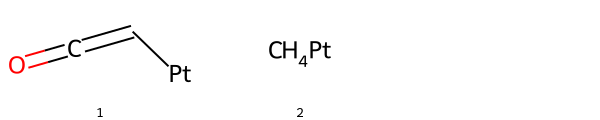


Products:


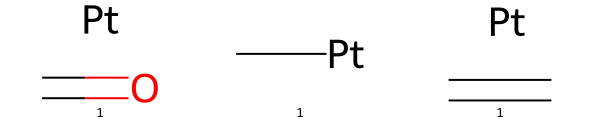


-----------------------------------------------------------------------------------------------------

CBH RUNG 2

Reactants:


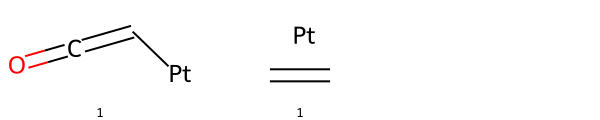


Products:


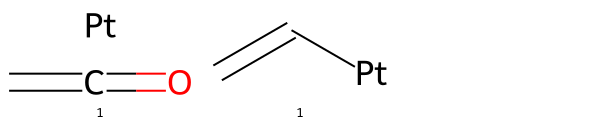

In [20]:
check.visualize()

In [21]:
dfs = calcCBH.generate_CBH_coeffs(['O=C(O)C(F)(OC(F)(F)C(F)(F)C(F)(F)F)C(F)(F)F',
                                   'O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'])
dfs[2].astype(int)

,CC(=O)O,CC(C)(F)F,CC(F)(F)F,CC(C)(O)F,CC(O)(F)F,COC,CC,CO,O=C(O)C(F)(OC(F)(F)C(F)(F)C(F)(F)F)C(F)(F)F,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
O=C(O)C(F)(OC(F)(F)C(F)(F)C(F)(F)F)C(F)(F)F,1,1,2,1,1,1,-4,-2,-1,0
O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,1,6,1,0,0,0,-7,0,0,-1


In [10]:
c = calcCBH(dataframe_path='../../CBH Schemes/Franklin_v5.pkl')
c.energies.loc[c.energies.loc[:,'source'] != 'ATcT', ['DfH', 'DrxnH']] = 0.0
c.energies.loc[c.energies.loc[:,'source'] == 'ATcT', ['DrxnH']] = 0.0
c.calc_Hf(saturate=[1,9], priority='rel_coeff')
hrxn_df, hf_df = c.calc_Hf_allrungs('C(F)(F)(F)C(F)(F)C(F)(F)(F)')

Process completed with errors in 23 species
These errors are likely to have propagated for the calculation of heats of formation of larger species.
Updating the reference values of species in the database will improve accuracy of heats of formation.
To inspect the errors, run the calcCBH.print_errors() method.


In [11]:
pd.DataFrame(hrxn_df)

,0,1,2,3
ref,2381.093000,1357.661000,1872.566097,1774.433171
anl0,626.609277,-378.627826,132.686443,32.638257
f12b,626.519802,-380.390070,133.998576,32.108287
m062x_dlpno,652.676769,-373.670722,134.717426,34.342189
wb97xd_dlpno,649.243563,-372.937182,134.048135,33.724406
b2plypd3,548.881726,-407.787370,126.585845,30.881128
m062x,499.401558,-412.014424,127.580909,34.370417
wb97xd,563.387612,-402.460231,125.950474,30.923136


In [12]:
pd.DataFrame(hf_df)

,0,1,2,3
ref,0.000000,0.000000,0.000000,0.000000
anl0,-1754.483723,-1736.288826,-1739.879654,-1741.794913
f12b,-1754.573198,-1738.051070,-1738.567522,-1742.324884
m062x_dlpno,-1728.416231,-1731.331722,-1737.848671,-1740.090981
wb97xd_dlpno,-1731.849437,-1730.598182,-1738.517963,-1740.708764
b2plypd3,-1832.211274,-1765.448370,-1745.980253,-1743.552043
m062x,-1881.691442,-1769.675424,-1744.985188,-1740.062753
wb97xd,-1817.705388,-1760.121231,-1746.615624,-1743.510035



-----------------------------------------------------------------------------------------------------

CBH RUNG 1

Reactants:


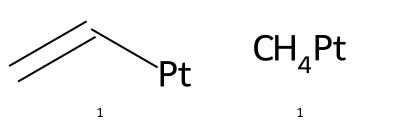


Products:


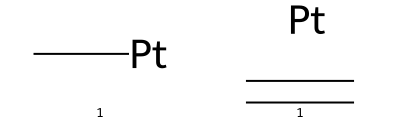

In [15]:
buildCBH('C=C[Pt]', saturate=1, surface_smiles='[Pt]').visualize(1)